In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pyodbc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score,GridSearchCV, StratifiedKFold
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE,ADASYN,SVMSMOTE,RandomOverSampler
from imblearn.pipeline import Pipeline as imbpipeline
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.preprocessing import RobustScaler
import dask.array as da
import dask.distributed

In [4]:
#ingore warnings
warnings.filterwarnings("ignore")
xgb.set_config(verbosity=0)
#to show more rows and columns in pandas Dataframe
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)

# Loading data files

## We use quality of care data from 2013-2015, due to the data acquisition of this database has two-year's delay, the data of hospital compare 2017 is actually 2015's, and so on. Our datasets' names are based on the hospital compare data aquisition year.

In [5]:
#loading closed hospital information
dataset_close_status=pd.read_csv('data\hospital_closure\hospital_closure.csv')

#loading Hospital Compare AHRQ data connect from MS Access files(.mdb)  
MDB_2017='data\hospital_compare\hc_apr2017\Hospital.mdb'
MDB_2016 = 'data\hospital_compare\hc_may2016\Hospital.mdb'
MDB_2015='data\hospital_compare\Copy of HospitalMay2015.mdb'
MDB_2014='data\hospital_compare\HC_May2014.mdb'
DRV = '{Microsoft Access Driver (*.mdb, *.accdb)}'
PWD = 'pw'
con_2017 = pyodbc.connect('DRIVER={};DBQ={};PWD={}'.format(DRV,MDB_2017,PWD))
con_2016 = pyodbc.connect('DRIVER={};DBQ={};PWD={}'.format(DRV,MDB_2016,PWD))
con_2015 = pyodbc.connect('DRIVER={};DBQ={};PWD={}'.format(DRV,MDB_2015,PWD))
cur_2017 = con_2017.cursor()
cur_2016 = con_2016.cursor()
cur_2015 = con_2015.cursor()

#SQL query to access data
table_name = 'HQI_HOSP_ReadmDeath'
table_name2='HQI_HOSP_ReadmCompDeath'
table_name3='HQI_HOSP_Comp'
query = "SELECT * FROM {}".format(table_name)
query2="SELECT * FROM {}".format(table_name2)
query3="SELECT * FROM {}".format(table_name3)
rows_2017=cur_2017.execute(query).fetchall()
rows_2017_c=cur_2017.execute(query3).fetchall()
rows_2016=cur_2016.execute(query).fetchall()
rows_2016_c=cur_2016.execute(query3).fetchall()
rows_2015=cur_2015.execute(query2).fetchall()

#generate pandas Dataframe using the scores of each variable
arr_2017=np.array(rows_2017)
dataset_2017=pd.DataFrame(arr_2017[:,[0,3,6]],columns=['id','score_name','Score'])
arr_2017_c=np.array(rows_2017_c)
dataset_2017_c=pd.DataFrame(arr_2017_c[:,[0,3,6]],columns=['id','score_name','Score'])
arr_2016=np.array(rows_2016)
dataset_2016=pd.DataFrame(arr_2016[:,[0,3,6]],columns=['id','score_name','Score'])
arr_2016_c=np.array(rows_2016_c)
dataset_2016_c=pd.DataFrame(arr_2016_c[:,[0,3,6]],columns=['id','score_name','Score'])
arr_2015=np.array(rows_2015)
dataset_2015=pd.DataFrame(arr_2015[:,[0,3,6]],columns=['id','score_name','Score'])


# Data Preprocessing

In [6]:
#drop abnormal Hospitals
dataset_2015=dataset_2015[dataset_2015['id'].map(lambda x: x.find('F')==-1)]
dataset_2015.drop(dataset_2015[dataset_2015.id=='670092'].index,inplace=True)
dataset_2016=dataset_2016[dataset_2016['id'].map(lambda x: x.find('F')==-1)]
dataset_2016_c=dataset_2016_c[dataset_2016_c['id'].map(lambda x: x.find('F')==-1)]

#combine the data of different variables in the same year
dataset_2016=pd.concat([dataset_2016,dataset_2016_c],axis=0)
dataset_2017=pd.concat([dataset_2017,dataset_2017_c],axis=0)

#re-sort the datasets
dataset_2015.sort_values(by=['id','score_name'],inplace=True)
dataset_2016.sort_values(by=['id','score_name'],inplace=True)
dataset_2017.sort_values(by=['id','score_name'],inplace=True)



In [7]:
#manually flatten the variables
dataset_2015_num=dataset_2015[['id','Score']].to_numpy().reshape(int(dataset_2015.id.value_counts().ne(1).sum()),int(dataset_2015.score_name.value_counts().ne(0).sum()*2))
dataset_2016_num=dataset_2016[['id','Score']].to_numpy().reshape(int(dataset_2016.id.value_counts().ne(1).sum()),int(dataset_2016.score_name.value_counts().ne(0).sum()*2))
dataset_2017_num=dataset_2017[['id','Score']].to_numpy().reshape(int(dataset_2017.id.value_counts().ne(1).sum()),int(dataset_2017.score_name.value_counts().ne(0).sum()*2))
arr_2015=[i*2 for i in range(dataset_2015.score_name.value_counts().ne(0).sum())]
arr_2016=[i*2 for i in range(dataset_2016.score_name.value_counts().ne(0).sum())]
arr_2017=[i*2 for i in range(dataset_2017.score_name.value_counts().ne(0).sum())]
dataset_2015=np.delete(dataset_2015_num,arr_2015[1:],axis=1)
dataset_2016=np.delete(dataset_2016_num,arr_2016[1:],axis=1)
dataset_2017=np.delete(dataset_2017_num,arr_2017[1:],axis=1)
dataset_2015=pd.DataFrame(dataset_2015,columns=['id','COMP_HIP_KNEE','MORT_30_AMI','MORT_30_COPD','MORT_30_HF','MORT_30_PN','MORT_30_STK','PSI_12_POSTOP_PULMEMB_DVT','PSI_14_POSTOP_DEHIS','PSI_15_ACC_LAC','PSI_4_SURG_COMP','PSI_6_IAT_PTX','PSI_90_SAFETY','READM_30_AMI','READM_30_COPD','READM_30_HF','READM_30_HIP_KNEE','READM_30_HOSP_WIDE','READM_30_PN','READM_30_STK'])
dataset_2016=pd.DataFrame(dataset_2016,columns=['id','COMP_HIP_KNEE','MORT_30_AMI','MORT_30_CABG','MORT_30_COPD','MORT_30_HF','MORT_30_PN','MORT_30_STK','PSI_12_POSTOP_PULMEMB_DVT','PSI_14_POSTOP_DEHIS','PSI_15_ACC_LAC','PSI_4_SURG_COMP','PSI_6_IAT_PTX','PSI_90_SAFETY','READM_30_AMI','READM_30_CABG','READM_30_COPD','READM_30_HF','READM_30_HIP_KNEE','READM_30_HOSP_WIDE','READM_30_PN','READM_30_STK'])
dataset_2017=pd.DataFrame(dataset_2017,columns=['id','COMP_HIP_KNEE','MORT_30_AMI','MORT_30_CABG','MORT_30_COPD','MORT_30_HF','MORT_30_PN','MORT_30_STK','PSI_12_POSTOP_PULMEMB_DVT','PSI_13_POST_SEPSIS','PSI_14_POSTOP_DEHIS','PSI_15_ACC_LAC','PSI_3_ULCER','PSI_4_SURG_COMP','PSI_6_IAT_PTX','PSI_7_CVCBI','PSI_8_POST_HIP','PSI_90_SAFETY','READM_30_AMI','READM_30_CABG','READM_30_COPD','READM_30_HF','READM_30_HIP_KNEE','READM_30_HOSP_WIDE','READM_30_PN','READM_30_STK'])

In [8]:
#drop the non-common variables in different years
dataset_2016.drop(columns=['MORT_30_CABG','READM_30_CABG'],inplace=True)
dataset_2017.drop(columns=['MORT_30_CABG','PSI_13_POST_SEPSIS','PSI_3_ULCER','PSI_7_CVCBI','PSI_8_POST_HIP','READM_30_CABG'],inplace=True)


In [9]:
#replace 'Not Available' with missing values
dataset_2017=dataset_2017.replace({'Not Available':np.nan,' Not Available':np.nan})
dataset_2016=dataset_2016.replace({'Not Available':np.nan,' Not Available':np.nan})
dataset_2015=dataset_2015.replace({'Not Available':np.nan,' Not Available':np.nan})

In [10]:
#make all data numeric
for col in dataset_2017:
    dataset_2017[col]=pd.to_numeric(dataset_2017[col])
for col in dataset_2016:
    dataset_2016[col]=pd.to_numeric(dataset_2016[col])
for col in dataset_2015:
    dataset_2015[col]=pd.to_numeric(dataset_2015[col])
#drop all the hospital data with all missing values    
dataset_2017.dropna(how='all',subset=['COMP_HIP_KNEE','MORT_30_AMI','MORT_30_COPD','MORT_30_HF','MORT_30_PN','MORT_30_STK','PSI_12_POSTOP_PULMEMB_DVT','PSI_14_POSTOP_DEHIS','PSI_15_ACC_LAC','PSI_4_SURG_COMP','PSI_6_IAT_PTX','PSI_90_SAFETY','READM_30_AMI','READM_30_COPD','READM_30_HF','READM_30_HIP_KNEE','READM_30_HOSP_WIDE','READM_30_PN','READM_30_STK'],inplace=True)
dataset_2016.dropna(how='all',subset=['COMP_HIP_KNEE','MORT_30_AMI','MORT_30_COPD','MORT_30_HF','MORT_30_PN','MORT_30_STK','PSI_12_POSTOP_PULMEMB_DVT','PSI_14_POSTOP_DEHIS','PSI_15_ACC_LAC','PSI_4_SURG_COMP','PSI_6_IAT_PTX','PSI_90_SAFETY','READM_30_AMI','READM_30_COPD','READM_30_HF','READM_30_HIP_KNEE','READM_30_HOSP_WIDE','READM_30_PN','READM_30_STK'],inplace=True)
dataset_2015.dropna(how='all',subset=['COMP_HIP_KNEE','MORT_30_AMI','MORT_30_COPD','MORT_30_HF','MORT_30_PN','MORT_30_STK','PSI_12_POSTOP_PULMEMB_DVT','PSI_14_POSTOP_DEHIS','PSI_15_ACC_LAC','PSI_4_SURG_COMP','PSI_6_IAT_PTX','PSI_90_SAFETY','READM_30_AMI','READM_30_COPD','READM_30_HF','READM_30_HIP_KNEE','READM_30_HOSP_WIDE','READM_30_PN','READM_30_STK'],inplace=True)

In [11]:
#assign Closure label
close_2017=dataset_close_status[dataset_close_status['year_close_combined']==2017]
close_2016=dataset_close_status[dataset_close_status['year_close_combined']==2016]
close_2015=dataset_close_status[dataset_close_status['year_close_combined']==2015]
close_2014=dataset_close_status[dataset_close_status['year_close_combined']==2014]
close_2013=dataset_close_status[dataset_close_status['year_close_combined']==2013]
close_2015_=pd.concat([close_2017,close_2016])
close_2014_=pd.concat([close_2016,close_2015])
close_2013_=pd.concat([close_2015,close_2014])

dataset_2017['Closure']=dataset_2017.id.apply(lambda x:1 if int(x) in np.array(close_2015_['id']) else 0)
#da_2017.drop(da_2017[da_2017['id']==any(close_2013['id'])].index,inplace=True)
#da_2017.drop(da_2017[da_2017['id']==any(close_2014['id'])].index,inplace=True)
dataset_2016['Closure']=dataset_2016.id.apply(lambda x:1 if int(x) in np.array(close_2014_['id']) else 0)
#da_2016.drop(da_2016[da_2016['id']==any(close_2013['id'])].index,inplace=True)
dataset_2015['Closure']=dataset_2015.id.apply(lambda x:1 if int(x) in np.array(close_2013_['id']) else 0)


In [123]:
dataset=pd.concat([dataset_2017,dataset_2016,dataset_2015])

dataset.loc[dataset['id']==40021,'Closure']=0
dataset.loc[dataset['id']==200025,'Closure']=0
dataset.loc[dataset['id']==260147,'Closure']=0
dataset.loc[dataset['id']==440047,'Closure']=0
dataset.loc[dataset['id']==180149,'Closure']=0
dataset.loc[dataset['id']==450832,'Closure']=0
dataset.loc[dataset['id']==670052,'Closure']=0
 
dataset['c']=dataset.apply(lambda x:1 if int(x['id']) in np.array(dataset_close_status['id']) and x['Closure']==0 else 0,axis=1)
dataset.drop(dataset[dataset['c']==1].index,inplace=True)
dataset.drop(columns=['c'],inplace=True)

In [124]:
dataset.drop(columns=['id'],inplace=True)

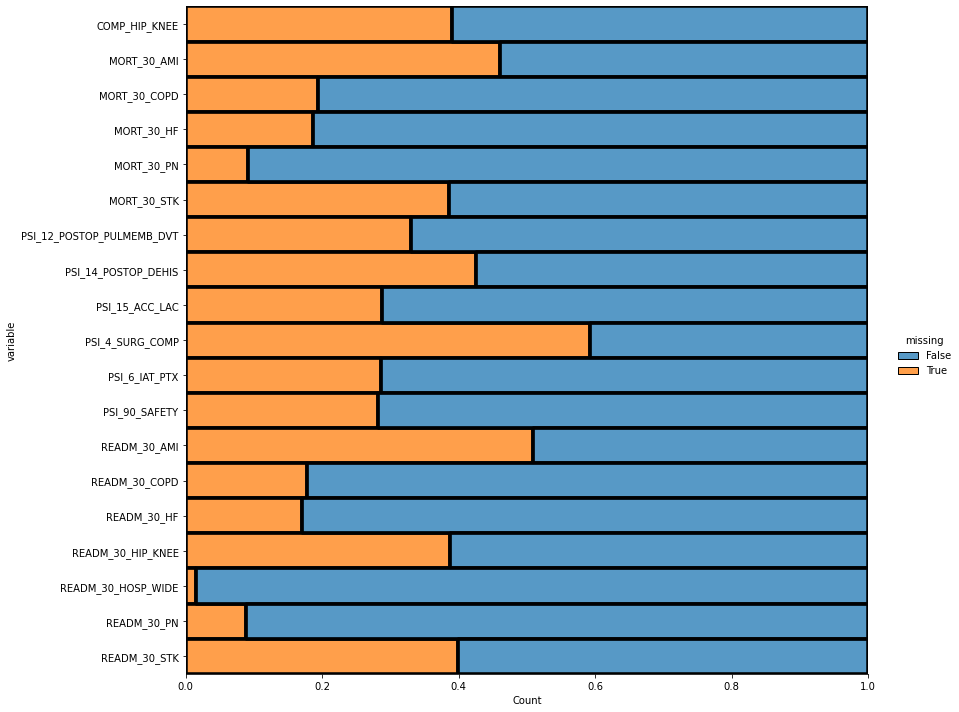

In [221]:
sns.displot(
    data=dataset.copy().drop(columns=['id','Closure']).isna().melt(value_name="missing"),
    
    y="variable",
    hue="missing",
    multiple="fill",
    height=10,
    aspect=1.25
)

In [19]:
dataset

,COMP_HIP_KNEE,MORT_30_AMI,MORT_30_COPD,MORT_30_HF,MORT_30_PN,MORT_30_STK,PSI_12_POSTOP_PULMEMB_DVT,PSI_14_POSTOP_DEHIS,PSI_15_ACC_LAC,PSI_4_SURG_COMP,PSI_6_IAT_PTX,PSI_90_SAFETY,READM_30_AMI,READM_30_COPD,READM_30_HF,READM_30_HIP_KNEE,READM_30_HOSP_WIDE,READM_30_PN,READM_30_STK,Closure
0,3.8,12.5,9.3,12.4,15.5,15.4,3.32,2.72,1.35,168.26,0.36,0.68,16.5,21.1,21.4,5.1,15.4,18.7,12.7,0
1,3.0,16.0,7.6,15.5,20.8,15.5,5.63,2.11,1.25,179.05,0.47,0.85,16.7,18.0,21.9,5.7,14.9,16.4,13.4,0
2,3.8,16.7,7.1,15.6,18.2,17.9,3.85,2.50,1.93,198.33,0.41,0.91,16.1,19.8,20.6,5.0,15.4,17.9,12.0,0
3,NaN,NaN,9.3,14.4,18.8,16.6,4.57,NaN,1.20,NaN,0.40,0.79,NaN,19.9,21.1,NaN,16.6,17.3,12.7,0
4,NaN,NaN,8.2,12.7,15.7,NaN,NaN,NaN,1.41,NaN,0.41,0.90,NaN,19.2,23.1,NaN,15.7,16.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4645,NaN,NaN,NaN,11.8,NaN,NaN,4.69,NaN,1.90,NaN,0.44,0.86,NaN,NaN,22.8,NaN,15.9,18.4,NaN,0
4646,NaN,NaN,7.8,11.1,11.1,NaN,3.88,1.86,2.02,NaN,0.39,0.83,NaN,20.4,22.7,NaN,15.9,18.5,NaN,0
4647,NaN,NaN,7.0,11.1,11.5,NaN,3.45,1.84,2.28,NaN,0.39,0.85,NaN,20.4,25.6,NaN,16.4,18.9,NaN,0
4648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.86,NaN,0.41,0.85,NaN,NaN,NaN,NaN,15.6,NaN,NaN,0


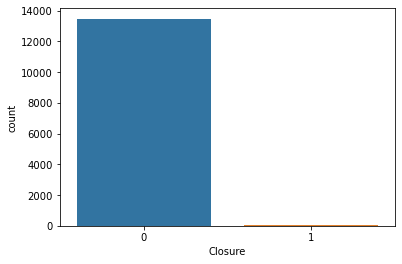

In [24]:
sns.countplot(x ='Closure', data=da_)

In [31]:
l=list(da_)
l

['id',
 'COMP_HIP_KNEE',
 'MORT_30_AMI',
 'MORT_30_COPD',
 'MORT_30_HF',
 'MORT_30_PN',
 'MORT_30_STK',
 'PSI_12_POSTOP_PULMEMB_DVT',
 'PSI_14_POSTOP_DEHIS',
 'PSI_15_ACC_LAC',
 'PSI_4_SURG_COMP',
 'PSI_6_IAT_PTX',
 'PSI_90_SAFETY',
 'READM_30_AMI',
 'READM_30_COPD',
 'READM_30_HF',
 'READM_30_HIP_KNEE',
 'READM_30_HOSP_WIDE',
 'READM_30_PN',
 'READM_30_STK',
 'Closure']

In [32]:
da_[da_['Closure']==0]['id'].value_counts().value_counts()

3    4538
1     266
2      90
Name: id, dtype: int64

In [108]:
dataset.fillna(0,inplace=True)


In [117]:
dataset.drop(columns=['PSI_4_SURG_COMP','READM_30_AMI','COMP_HIP_KNEE','MORT_30_AMI','MORT_30_STK','READM_30_HIP_KNEE','READM_30_STK'],inplace=True)

In [134]:
pd_list=list(da_.columns)

In [131]:
imputer_i=IterativeImputer(max_iter=50)
imputer_i.fit(dataset)
da_=imputer_i.transform(dataset)
dataset_=da_

In [130]:
da_

,COMP_HIP_KNEE,MORT_30_AMI,MORT_30_COPD,MORT_30_HF,MORT_30_PN,MORT_30_STK,PSI_12_POSTOP_PULMEMB_DVT,PSI_14_POSTOP_DEHIS,PSI_15_ACC_LAC,PSI_4_SURG_COMP,PSI_6_IAT_PTX,PSI_90_SAFETY,READM_30_AMI,READM_30_COPD,READM_30_HF,READM_30_HIP_KNEE,READM_30_HOSP_WIDE,READM_30_PN,READM_30_STK,Closure,MORT,PSI,READM
0,3.800000,12.500000,9.300000,12.400000,15.500000,15.400000,3.320000,2.720000,1.350000,168.260000,0.360000,0.680000,16.500000,21.100000,21.400000,5.100000,15.400000,18.700000,12.700000,0.0,13.020000,29.448333,15.842857
1,3.000000,16.000000,7.600000,15.500000,20.800000,15.500000,5.630000,2.110000,1.250000,179.050000,0.470000,0.850000,16.700000,18.000000,21.900000,5.700000,14.900000,16.400000,13.400000,0.0,15.080000,31.560000,15.285714
2,3.800000,16.700000,7.100000,15.600000,18.200000,17.900000,3.850000,2.500000,1.930000,198.330000,0.410000,0.910000,16.100000,19.800000,20.600000,5.000000,15.400000,17.900000,12.000000,0.0,15.100000,34.655000,15.257143
3,3.076081,15.038000,9.300000,14.400000,18.800000,16.600000,4.570000,2.342799,1.200000,143.431453,0.400000,0.790000,17.028574,19.900000,21.100000,4.783944,16.600000,17.300000,12.700000,0.0,14.827600,25.455709,15.630360
4,3.170740,14.477130,8.200000,12.700000,15.700000,15.200290,5.536229,2.201928,1.410000,133.972495,0.410000,0.900000,17.076684,19.200000,23.100000,4.761200,15.700000,16.000000,12.733444,0.0,13.255484,24.071775,15.510190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14097,3.045340,14.366075,8.249097,12.406076,15.492585,15.313579,4.440000,2.201127,1.760000,132.095592,0.400000,0.920000,16.751049,19.668513,21.425813,4.594652,14.900000,16.607818,12.332930,0.0,13.165482,23.636120,15.182968
14098,3.190826,14.386410,7.926856,11.975637,13.340015,15.054018,4.526810,1.986139,1.725577,124.888678,0.401127,0.849841,17.207230,20.314497,22.194789,4.903777,15.470887,17.114840,12.844884,0.0,12.536587,22.396362,15.721558
14099,3.190826,14.386410,7.926856,11.975637,13.340015,15.054018,4.526810,1.986139,1.725577,124.888678,0.401127,0.849841,17.207230,20.314497,22.194789,4.903777,15.470887,17.114840,12.844884,0.0,12.536587,22.396362,15.721558
14100,3.190826,14.386410,7.926856,11.975637,13.340015,15.054018,4.526810,1.986139,1.725577,124.888678,0.401127,0.849841,17.207230,20.314497,22.194789,4.903777,15.470887,17.114840,12.844884,0.0,12.536587,22.396362,15.721558


In [136]:
dataset_=pd.DataFrame(data=dataset_,columns=pd_list)

In [137]:
dataset_

,COMP_HIP_KNEE,MORT_30_AMI,MORT_30_COPD,MORT_30_HF,MORT_30_PN,MORT_30_STK,PSI_12_POSTOP_PULMEMB_DVT,PSI_14_POSTOP_DEHIS,PSI_15_ACC_LAC,PSI_4_SURG_COMP,PSI_6_IAT_PTX,PSI_90_SAFETY,READM_30_AMI,READM_30_COPD,READM_30_HF,READM_30_HIP_KNEE,READM_30_HOSP_WIDE,READM_30_PN,READM_30_STK,year,Closure
0,3.800000,12.500000,9.300000,12.400000,15.500000,15.400000,3.320000,2.720000,1.350000,168.260000,0.360000,0.680000,16.500000,21.100000,21.40000,5.100000,15.400000,18.700000,12.700000,2015.0,0.0
1,3.000000,16.000000,7.600000,15.500000,20.800000,15.500000,5.630000,2.110000,1.250000,179.050000,0.470000,0.850000,16.700000,18.000000,21.90000,5.700000,14.900000,16.400000,13.400000,2015.0,0.0
2,3.800000,16.700000,7.100000,15.600000,18.200000,17.900000,3.850000,2.500000,1.930000,198.330000,0.410000,0.910000,16.100000,19.800000,20.60000,5.000000,15.400000,17.900000,12.000000,2015.0,0.0
3,3.066476,14.971088,9.300000,14.400000,18.800000,16.600000,4.570000,2.345524,1.200000,144.008049,0.400000,0.790000,16.977660,19.900000,21.10000,4.763397,16.600000,17.300000,12.700000,2015.0,0.0
4,3.095940,14.211826,8.200000,12.700000,15.700000,15.000105,5.388550,2.225476,1.410000,135.987433,0.410000,0.900000,16.850031,19.200000,23.10000,4.641372,15.700000,16.000000,12.571361,2015.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14097,3.280343,15.001335,8.115979,12.317502,12.756045,15.557078,4.440000,2.063580,1.760000,121.159453,0.400000,0.920000,17.517210,20.223480,22.01718,5.041223,14.900000,16.775460,12.926631,2013.0,0.0
14098,3.331105,14.793242,7.843491,11.926662,11.259635,15.234264,4.192507,1.793307,1.804869,115.798110,0.399777,0.798666,17.678250,20.667871,22.53174,5.189735,15.447033,17.185376,13.207623,2013.0,0.0
14099,3.331105,14.793242,7.843491,11.926662,11.259635,15.234264,4.192507,1.793307,1.804869,115.798110,0.399777,0.798666,17.678250,20.667871,22.53174,5.189735,15.447033,17.185376,13.207623,2013.0,0.0
14100,3.331105,14.793242,7.843491,11.926662,11.259635,15.234264,4.192507,1.793307,1.804869,115.798110,0.399777,0.798666,17.678250,20.667871,22.53174,5.189735,15.447033,17.185376,13.207623,2013.0,0.0


In [127]:
tem=tem.reset_index(name='id')

In [45]:
tem

,index,id
0,0,10001
1,1,10005
2,2,10006
3,3,10007
4,4,10008
...,...,...
14097,4649,670085
14098,4650,670087
14099,4651,670088
14100,4652,670089


In [128]:
dataset_=pd.concat([dataset_,tem],axis=1)

In [129]:
dataset_.drop(columns=['Closure','index'],inplace=True)

In [130]:
dataset_.to_csv('q.csv')

In [98]:
dataset_

array([[ 9.3       , 12.4       , 15.5       , ..., 15.4       ,
        18.7       ,  0.        ],
       [ 7.6       , 15.5       , 20.8       , ..., 14.9       ,
        16.4       ,  0.        ],
       [ 7.1       , 15.6       , 18.2       , ..., 15.4       ,
        17.9       ,  0.        ],
       ...,
       [ 7.        , 11.1       , 11.5       , ..., 16.4       ,
        18.9       ,  0.        ],
       [ 7.92074598, 11.97704175, 12.92992177, ..., 15.6       ,
        17.2267352 ,  0.        ],
       [ 8.18990252, 12.32553865, 15.43804555, ..., 14.9       ,
        16.60641515,  0.        ]])

In [133]:
dataset_=np.concatenate((dataset_,Y.to_numpy().reshape(da_.shape[0],1)),axis=1)

In [15]:
dataset_

array([[ 3.8       , 12.5       ,  9.3       , ..., 18.7       ,
        12.7       ,  0.        ],
       [ 3.        , 16.        ,  7.6       , ..., 16.4       ,
        13.4       ,  0.        ],
       [ 3.8       , 16.7       ,  7.1       , ..., 17.9       ,
        12.        ,  0.        ],
       ...,
       [ 3.35411798, 14.52856279,  7.        , ..., 18.9       ,
        13.78884871,  0.        ],
       [ 3.20944141, 14.44387354,  7.91101322, ..., 17.2259266 ,
        12.93918622,  0.        ],
       [ 3.04612855, 14.37313007,  8.25150423, ..., 16.60690519,
        12.33239572,  0.        ]])

In [99]:
dataset_=dataset.to_numpy()

In [138]:
dataset_.drop(columns=['year'],inplace=True)

In [132]:
scaler = RobustScaler()
dataset_ = scaler.fit_transform(dataset_)

In [118]:
dataset_=dataset.to_numpy()

In [137]:
train, test = train_test_split(dataset_, test_size=0.2,stratify=dataset_[:,-1])
X_train = train[:,:-1]
Y_train = train[:,-1].astype(int)
X_test  = test[:,:-1]
Y_test  = test[:,-1].astype(int)
X_train.shape, Y_train.shape,X_test.shape, Y_test.shape

((10768, 19), (10768,), (2692, 19), (2692,))

In [111]:
smote = RandomOverSampler()
x_smote , y_smote = smote.fit_sample(X_train, Y_train)
x_train1, y_train1 = x_smote , y_smote
x_test1 =X_test

In [153]:
pipeline = imbpipeline(steps = [['oversampling', RandomOverSampler()],['classifier', XGBClassifier()]])
np.array(cross_val_score(pipeline,X_train, y_train,scoring='f1',
        cv=stratified_kfold,
        n_jobs=-1)).mean()

0.3279797979797979

In [25]:
m=XGBClassifier()
m.fit(x_train1, y_train1)
predict_y = m.predict(x_test1)

print('F1 score:',f1_score(Y_test, predict_y))
print(classification_report(Y_test, predict_y))
confusion_matrix(Y_test, predict_y)

F1 score: 0.2222222222222222
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2684
           1       1.00      0.12      0.22         8

    accuracy                           1.00      2692
   macro avg       1.00      0.56      0.61      2692
weighted avg       1.00      1.00      1.00      2692



array([[2684,    0],
       [   7,    1]], dtype=int64)

In [152]:
X_train, X_test, y_train, y_test = train_test_split(dataset_[:,:-1],
                                                    dataset_[:,-1],
                                                    test_size=0.2,
                                                    stratify=dataset_[:,-1]
                                                    )
stratified_kfold = StratifiedKFold(n_splits=5,
                                       
                                       )

In [154]:
cluster = dask.distributed.LocalCluster()
client = dask.distributed.Client(cluster)

In [155]:
dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train)

Windows is not officially supported for dask/xgboost, contribution are welcomed.


TypeError: Expecting <class 'dask.dataframe.core.DataFrame'> or <class 'dask.array.core.Array'>.  Got <class 'numpy.ndarray'>

In [ ]:
# Classifier
pipeline = imbpipeline(steps = [['smote', RandomOverSampler()],
                                
                                ['classifier', LogisticRegression()]])
bayes_search = BayesSearchCV(
    estimator = pipeline,
    search_spaces = {
        'classifier__learning_rate': (0.01, 1.0, 'log-uniform'),
        'classifier__min_child_weight': (0, 10),
        'classifier__max_depth': (0, 50),
        'classifier__max_delta_step': (0, 20),
        'classifier__subsample': (0.01, 1.0, 'uniform')
        
    },    
    scoring = 'f1',
    cv = stratified_kfold,
    n_jobs = -1      
)
bayes_search.fit(X_train, y_train)
cv_score_RF_s = bayes_search.best_score_
test_score_RF_s = bayes_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_RF_s}\nTest score: {test_score_RF_s}')

In [47]:
# Classifier
pipeline = imbpipeline(steps = [['smote', SMOTE()],
                                
                                ['classifier', LogisticRegression(solver='saga')]])
bayes_search = BayesSearchCV(
    estimator = pipeline,
    search_spaces = {
        'classifier__penalty':['l1','l2','elasticnet','none'],
        'classifier__C': (1e-6, 1e+6, 'log-uniform'),
        'classifier__max_iter': (100, 1e+6,'log-uniform'),
        'classifier__l1_ratio': (0,1)
    },    
    scoring = 'f1',
    cv = stratified_kfold,
    n_jobs = -1      
)
bayes_search.fit(X_train, y_train)
cv_score_LR_s = bayes_search.best_score_
test_score_LR_s= bayes_search.score(X_test, y_test)
best_estimator=pd.DataFrame(bayes_search.cv_results_)[pd.DataFrame(bayes_search.cv_results_)['rank_test_score']==1]
orderd_dict_best_params=best_estimator.iloc[0]['params']
list_best_cv_LR_s=[]
for col in best_estimator:
    if 'split' in col:
        if 'test_score' in col:
            list_best_cv_LR_s.append(float(best_estimator[col]))
print(f'Cross-validation score: {cv_score_LR_s}\nTest score: {test_score_LR_s}')
print(f'Best parameters: '+str(dict(orderd_dict_best_params)))

Cross-validation score: 0.02833741710337817
Test score: 0.030418250950570346


In [35]:
def bayes_tuning(oversampling,classifier,search_spaces):
    pipeline = imbpipeline(steps = [['oversampling', oversampling],['classifier', classifier]])
    bayes_search = BayesSearchCV(
        estimator = pipeline,
        search_spaces=search_spaces,    
        scoring='f1',
        cv=stratified_kfold,
        n_jobs=-1)
    bayes_search.fit(X_train, y_train)
    cv_score= bayes_search.best_score_
    test_score= bayes_search.score(X_test, y_test)
    best_estimator=pd.DataFrame(bayes_search.cv_results_)[pd.DataFrame(bayes_search.cv_results_)['rank_test_score']==1]
    orderd_dict_best_params=best_estimator.iloc[0]['params']
    list_best_cv=[]
    for col in best_estimator:
        if 'test_score' in col:
            if 'split' in col:
                list_best_cv.append(float(best_estimator.iloc[0:1][col]))
    print(f'Classifier: {str(classifier)}\nOver-sampling strategy: {str(oversampling)}\nCross-validation score: {cv_score}\nTest score: {test_score}\nBest parameters: {str(dict(orderd_dict_best_params))}')
    return cv_score,test_score,list_best_cv


In [36]:
def grid_tuning(oversampling,classifier,search_spaces):
    pipeline = imbpipeline(steps = [['oversampling', oversampling],['classifier', classifier]])
    grid_search = GridSearchCV(
        estimator = pipeline,
        param_grid=search_spaces,    
        scoring='f1',
        cv=stratified_kfold,
        n_jobs=-1)
    grid_search.fit(X_train, y_train)
    cv_score= grid_search.best_score_
    test_score= grid_search.score(X_test, y_test)
    best_estimator=pd.DataFrame(grid_search.cv_results_)[pd.DataFrame(grid_search.cv_results_)['rank_test_score']==1]
    orderd_dict_best_params=best_estimator.iloc[0]['params']
    list_best_cv=[]
    for col in best_estimator[best_estimator.index==0]:
        if 'test_score' in col:
            if 'split' in col:
                list_best_cv.append(float(best_estimator.iloc[0:1][col]))
    print(f'Classifier: {str(classifier)}\nOver-sampling strategy: {str(oversampling)}\nCross-validation score: {cv_score}\nTest score: {test_score}\nBest parameters: {str(dict(orderd_dict_best_params))}')
    return cv_score,test_score,list_best_cv

In [362]:
classifier=LogisticRegression()
param_space={'classifier__C':(1e-5,1e+5,'log-uniform')}
oversampling=RandomOverSampler()
cv_score_LR_r,test_score_LR_r,list_best_cv_LR_r=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=SMOTE()
cv_score_LR_s,test_score_LR_s,list_best_cv_LR_s=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=ADASYN()
cv_score_LR_a,test_score_LR_a,list_best_cv_LR_a=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=SVMSMOTE()
cv_score_LR_svm,test_score_LR_svm,list_best_cv_LR_svm=bayes_tuning(oversampling,classifier,param_space)
print('')

Classifier: LogisticRegression()
Over-sampling strategy: RandomOverSampler()
Cross-validation score: 0.030330187067986476
Test score: 0.03007518796992481
Best parameters: {'classifier__C': 0.00044511874201840846}

Classifier: LogisticRegression()
Over-sampling strategy: SMOTE()
Cross-validation score: 0.029871652929680657
Test score: 0.02985074626865672
Best parameters: {'classifier__C': 0.0006903994500085412}

Classifier: LogisticRegression()
Over-sampling strategy: ADASYN()
Cross-validation score: 0.029708884725381485
Test score: 0.030534351145038167
Best parameters: {'classifier__C': 0.0008147780990529244}

Classifier: LogisticRegression()
Over-sampling strategy: SVMSMOTE()
Cross-validation score: 0.02294991076628717
Test score: 0.026666666666666665
Best parameters: {'classifier__C': 100000.0}



In [711]:
classifier=KNeighborsClassifier()
param_space={'classifier__n_neighbors':Integer(1,100)}
oversampling=RandomOverSampler()
cv_score_knn_r,test_score_knn_r,list_best_cv_knn_r=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=SMOTE()
cv_score_knn_s,test_score_knn_s,list_best_cv_knn_s=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=ADASYN()
cv_score_knn_a,test_score_knn_a,list_best_cv_knn_a=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=SVMSMOTE()
cv_score_knn_svm,test_score_knn_svm,list_best_cv_knn_svm=bayes_tuning(oversampling,classifier,param_space)
print('')

Classifier: KNeighborsClassifier()
Over-sampling strategy: RandomOverSampler()
Cross-validation score: 0.24769505004799122
Test score: 0.10526315789473685
Best parameters: {'classifier__n_neighbors': 4}

Classifier: KNeighborsClassifier()
Over-sampling strategy: SMOTE()
Cross-validation score: 0.2334189886480908
Test score: 0.09523809523809523
Best parameters: {'classifier__n_neighbors': 2}

Classifier: KNeighborsClassifier()
Over-sampling strategy: ADASYN()
Cross-validation score: 0.22949742002063983
Test score: 0.09523809523809523
Best parameters: {'classifier__n_neighbors': 1}

Classifier: KNeighborsClassifier()
Over-sampling strategy: SVMSMOTE()
Cross-validation score: 0.25559251559251556
Test score: 0.0
Best parameters: {'classifier__n_neighbors': 2}



In [363]:
classifier=DecisionTreeClassifier()
param_space={'classifier__criterion':Categorical(['gini','entropy']),
            'classifier__max_depth': Integer(1,1000),
            'classifier__splitter':Categorical(['best','random']),
            'classifier__min_samples_split': Integer(2,50),
            'classifier__min_samples_leaf': Integer(1,50),
            'classifier__max_features':Categorical(['auto','sqrt','log2',None])
            }
oversampling=RandomOverSampler()
cv_score_dt_r,test_score_dt_r,list_best_cv_dt_r=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=SMOTE()
cv_score_dt_s,test_score_dt_s,list_best_cv_dt_s=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=ADASYN()
cv_score_dt_a,test_score_dt_a,list_best_cv_dt_a=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=SVMSMOTE()
cv_score_dt_svm,test_score_dt_svm,list_best_cv_dt_svm=bayes_tuning(oversampling,classifier,param_space)
print('')

Classifier: DecisionTreeClassifier()
Over-sampling strategy: RandomOverSampler()
Cross-validation score: 0.3671794871794872
Test score: 0.25
Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 1000, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 50, 'classifier__splitter': 'best'}

Classifier: DecisionTreeClassifier()
Over-sampling strategy: SMOTE()
Cross-validation score: 0.2724761904761904
Test score: 0.2
Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 1000, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 50, 'classifier__splitter': 'best'}

Classifier: DecisionTreeClassifier()
Over-sampling strategy: ADASYN()
Cross-validation score: 0.3222399432925748
Test score: 0.0
Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 763, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, '

In [144]:
classifier=RandomForestClassifier()
param_space={'classifier__n_estimators':Integer(10,500),
            'classifier__criterion':Categorical(['gini','entropy']),
            'classifier__max_depth': Integer(1,1000),
            'classifier__min_samples_split': Integer(2,50),
            'classifier__min_samples_leaf': Integer(1,50),
            'classifier__max_features':Categorical(['auto','sqrt','log2']),
            'classifier__max_leaf_nodes': Integer(2,50),
            'classifier__min_weight_fraction_leaf': Real(0,0.5)
            }
oversampling=RandomOverSampler()
cv_score_rf_r,test_score_rf_r,list_best_cv_rf_r=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=SMOTE()
cv_score_rf_s,test_score_rf_s,list_best_dt_rf_s=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=ADASYN()
cv_score_rf_a,test_score_rf_a,list_best_cv_rf_a=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=SVMSMOTE()
cv_score_rf_svm,test_score_rf_svm,list_best_cv_rf_svm=bayes_tuning(oversampling,classifier,param_space)
print('')

Classifier: RandomForestClassifier()
Over-sampling strategy: RandomOverSampler()
Cross-validation score: 0.4923809523809524
Test score: 0.3333333333333333
Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 1000, 'classifier__max_features': 'auto', 'classifier__max_leaf_nodes': 36, 'classifier__min_samples_leaf': 28, 'classifier__min_samples_split': 45, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__n_estimators': 500}

Classifier: RandomForestClassifier()
Over-sampling strategy: SMOTE()
Cross-validation score: 0.49373015873015885
Test score: 0.28571428571428575
Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 924, 'classifier__max_features': 'auto', 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__n_estimators': 500}

Classifier: RandomForestClassifier()
Over-sampling strategy: ADASYN()
Cross-validation score

In [42]:
classifier=XGBClassifier(booster='gbtree',verbosity=0, tree_method='gpu_hist')
param_space={'classifier__learning_rate': (0.01, 1.0, 'log-uniform'),
             'classifier__min_child_weight': (0, 10),
             'classifier__max_depth': (0, 31),
             'classifier__max_delta_step': (0, 10),
             'classifier__subsample': (0.01, 1.0, 'uniform'),             
             'classifier__alpha': (1e-5, 1.0, 'log-uniform'),
             'classifier__min_child_weight': (0, 5),
             'classifier__n_estimators': (10, 500)   
        }
oversampling=RandomOverSampler()
cv_score_xg_r,test_score_xg_r,list_best_cv_xg_r=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=SMOTE()
cv_score_xg_s,test_score_xg_s,list_best_cv_xg_s=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=ADASYN()
cv_score_xg_a,test_score_xg_a,list_best_cv_xg_a=bayes_tuning(oversampling,classifier,param_space)
print('')
oversampling=SVMSMOTE()
cv_score_xg_svm,test_score_xg_svm,list_best_cv_xg_svm=bayes_tuning(oversampling,classifier,param_space)
print('')

XGBoostError: [19:17:00] c:\users\administrator\workspace\xgboost-win64_release_1.4.0\src\data\../common/device_helpers.cuh:414: Memory allocation error on worker 0: Caching allocator
- Free memory: 5361172480
- Requested memory: 2147483640


In [392]:
pipeline_rf=imbpipeline(steps = [['oversampling', SMOTE()],
                                
                                ['classifier', RandomForestClassifier(
                                    criterion= 'entropy',
                                    max_depth= 924,
                                    max_features= 'auto',
                                    max_leaf_nodes=50,
                                    min_samples_leaf= 1,
                                    min_samples_split= 2,
                                    min_weight_fraction_leaf= 0.0,
                                    n_estimators= 500
                                )]])

pipeline_xg=imbpipeline(steps=[['oversampling', SMOTE()],
                                ['classifier',XGBClassifier(booster='gbtree',silent=True,verbosity = 0,
                                alpha= 0.00019021955720011744,
                                learning_rate=  0.3971429889024503,
                                max_delta_step= 5,
                                classifier__max_depth= 34,
                                classifier__min_child_weight=2,
                                classifier__n_estimators= 464,
                                classifier__subsample=0.6137121540959071)]])

pipeline_df=imbpipeline(steps=[['oversampling', RandomOverSampler()],
                                ['classifier',DecisionTreeClassifier(
                                criterion='entropy',
                                max_depth=1000,
                                max_features=None,
                                min_samples_leaf= 1,
                                min_samples_split=50,
                                splitter= 'best')]])


estimators=[('rf',pipeline_rf),('xg',pipeline_rf),('dt',DecisionTreeClassifier())]
stacking_clf=StackingClassifier(estimators=estimators,final_estimator=LogisticRegression())
list_cv_stacking=cross_val_score(stacking_clf,X_train, y_train,scoring='f1',
        cv=stratified_kfold,
        n_jobs=-1)
cv_score_stacking=list_cv_stacking.mean()
stacking_clf.fit(X_train, y_train)
predict_y = m.predict(X_test)
test_score_stacking=f1_score(y_test, predict_y)
print(f'Cross-validation score: {cv_score_stacking}\nTest score: {test_score_stacking}')

Cross-validation score: 0.38707070707070707
Test score: 1.0


In [384]:

predict_y=cross_val_predict(stacking_clf,X_train, y_train,
        cv=stratified_kfold,
        n_jobs=-1)

In [391]:
predict_y = stacking_clf.predict(X_test)
print('F1 score:',f1_score(y_test, predict_y))

F1 score: 0.4
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1342
         1.0       1.00      0.25      0.40         4

    accuracy                           1.00      1346
   macro avg       1.00      0.62      0.70      1346
weighted avg       1.00      1.00      1.00      1346



array([[1342,    0],
       [   3,    1]], dtype=int64)

In [389]:
stacking_clf.fit(X_train, y_train)
predict_y = stacking_clf.predict(X_test)
print('F1 score:',f1_score(y_test, predict_y))
print(classification_report(y_test, predict_y))
confusion_matrix(y_test, predict_y)

ValueError: Found input variables with inconsistent numbers of samples: [1346, 2692]

dict_keys(['estimators', 'flatten_transform', 'n_jobs', 'verbose', 'voting', 'weights', 'rf', 'xg', 'dt', 'hg', 'rf__bootstrap', 'rf__ccp_alpha', 'rf__class_weight', 'rf__criterion', 'rf__max_depth', 'rf__max_features', 'rf__max_leaf_nodes', 'rf__max_samples', 'rf__min_impurity_decrease', 'rf__min_impurity_split', 'rf__min_samples_leaf', 'rf__min_samples_split', 'rf__min_weight_fraction_leaf', 'rf__n_estimators', 'rf__n_jobs', 'rf__oob_score', 'rf__random_state', 'rf__verbose', 'rf__warm_start', 'xg__objective', 'xg__use_label_encoder', 'xg__base_score', 'xg__booster', 'xg__colsample_bylevel', 'xg__colsample_bynode', 'xg__colsample_bytree', 'xg__gamma', 'xg__gpu_id', 'xg__importance_type', 'xg__interaction_constraints', 'xg__learning_rate', 'xg__max_delta_step', 'xg__max_depth', 'xg__min_child_weight', 'xg__missing', 'xg__monotone_constraints', 'xg__n_estimators', 'xg__n_jobs', 'xg__num_parallel_tree', 'xg__random_state', 'xg__reg_alpha', 'xg__reg_lambda', 'xg__scale_pos_weight', 'xg__

In [628]:
models_comparsion = pd.DataFrame({
    'Model': ['Logistic Regression','K Nearest Neighbors',
              'Decision Tree','Random Forest', 
              'XGBoost'],
    'Random Over-Sampling':[cv_score_LR_r,cv_score_knn_r,cv_score_dt_r,cv_score_rf_r,cv_score_xg_r],
    'SMOTE': [cv_score_LR_s,cv_score_knn_s,cv_score_dt_s,cv_score_rf_s,cv_score_xg_s],
    'ADASYN': [cv_score_LR_a,cv_score_knn_a,cv_score_dt_a,cv_score_rf_a,cv_score_xg_a],
    'SVMSMOTE':[cv_score_LR_svm,cv_score_knn_svm,cv_score_dt_svm,cv_score_rf_svm,cv_score_xg_svm]
    })

In [629]:
models_comparsion

,Model,Random Over-Sampling,SMOTE,ADASYN,SVMSMOTE
0,Logistic Regression,0.030330,0.029872,0.029709,0.022950
1,K Nearest Neighbors,0.247695,0.231402,0.229497,0.254804
2,Decision Tree,0.367179,0.272476,0.322240,0.321763
3,Random Forest,0.492381,0.493730,0.453205,0.427619
4,XGBoost,0.544476,0.610501,0.590898,0.599401


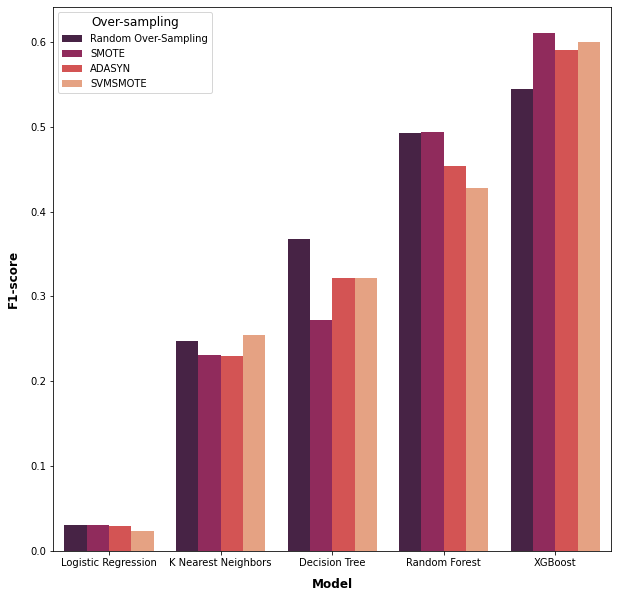

In [630]:
models_comparsion_barplot=models_comparsion.melt(id_vars='Model').rename(columns={'variable':'Oversampling','value':'f1-score'})
fig,_=plt.subplots(figsize=(10, 10))
sns.barplot(x="Model", y='f1-score',hue='Oversampling',data=models_comparsion_barplot,palette="rocket")
plt.xlabel('Model',labelpad=10,fontsize='large',fontweight='bold')
plt.ylabel('F1-score',labelpad=10,fontsize='large',fontweight='bold')
plt.legend(title='Over-sampling',title_fontsize='large')
plt.title('')
plt.show()

In [511]:
list_best_cv_knn_r

[0.26666666666666666,
 0.2,
 0.0,
 0.0,
 0.4444444444444445,
 0.30769230769230765,
 0.36363636363636365,
 0.14285714285714288,
 0.4,
 0.28571428571428575]

In [591]:
list_best_cv_xg_r

[0.6, 0.5454545454545454, 0.6153846153846154, 0.4615384615384615, 0.5]

In [616]:
list_best_cv_rf_r=[0.3333333333333333,
 0.5714285714285715,
 0.4,
 0.5714285714285715,
 0.5714285714285715]

In [632]:
cv_score=pd.DataFrame({
    'Logistic Regression':list_best_cv_LR_r,
    'K Nearest Neighbors':list_best_cv_knn_svm,
    'Decision Tree':list_best_cv_dt_r,
    'Random Forest':list_best_cv_rf_r, 
    'XGBoost':list_best_dt_xg_s
    })


In [642]:
test_score=pd.DataFrame({
    'Logistic Regression':test_score_LR_r,
    'K Nearest Neighbors':test_score_knn_svm,
    'Decision Tree':test_score_dt_r,
    'Random Forest':test_score_rf_r, 
    'XGBoost':test_score_xg_s
})

ValueError: If using all scalar values, you must pass an index

In [637]:
np.array(list_best_dt_xg_s).std()

0.03931911764557515

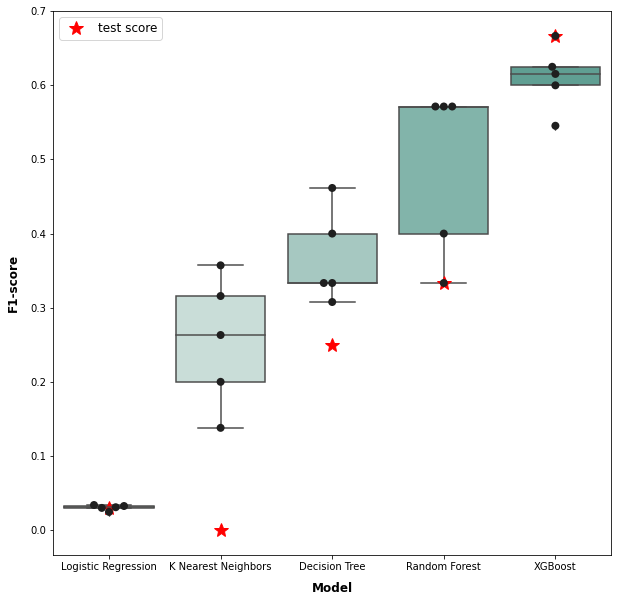

In [710]:
fig,_=plt.subplots(figsize=(10, 10))
sns.boxplot(data=cv_score,palette='light:#5A9')
sns.swarmplot(data=cv_score,color='.12',size=8)
plt.xlabel('Model',labelpad=10,fontsize='large',fontweight='bold')
plt.ylabel('F1-score',labelpad=10,fontsize='large',fontweight='bold')
plt.plot(x,y,'*',color='r',markersize=14,label='test score')
plt.legend(loc='upper left',fontsize=12)


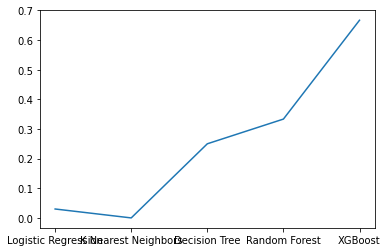

In [644]:
myList = test_score.items()
 
x, y = zip(*myList) 

plt.plot(x, y)